In [1]:
%load_ext autoreload
%autoreload 2
import scipy
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import keras

import time

2024-06-10 07:50:49.646541: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-10 07:50:49.816150: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-10 07:50:49.816193: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-10 07:50:49.817383: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-10 07:50:49.827697: I tensorflow/core/platform/cpu_feature_guar

2024-06-10 07:51:33.840460: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-06-10 07:51:33.840498: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: s1cmp008.pax.tufts.edu
2024-06-10 07:51:33.840506: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: s1cmp008.pax.tufts.edu
2024-06-10 07:51:33.840607: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.129.3
2024-06-10 07:51:33.840634: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.129.3
2024-06-10 07:51:33.840640: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.129.3


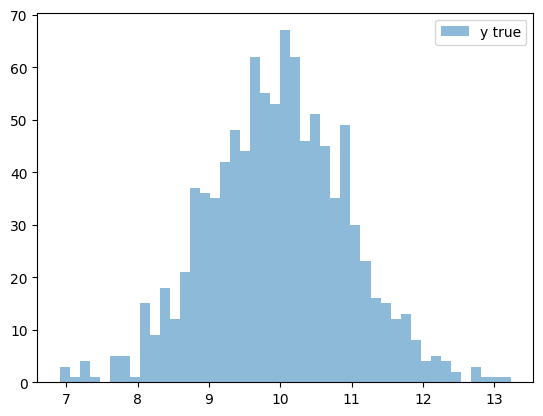

In [2]:
S=1
scale = 1
means = [10]
# simulate data for each location
data_distributions = [scipy.stats.norm(loc=mean, scale=scale) for mean in means]

T=1000
# create random state for sampling
seed=360
rng = np.random.RandomState(seed)
y_TS = np.array([dist.rvs(size=T, random_state=rng) for dist in data_distributions]).T
assert(y_TS.shape == (T, S))

# empty input
x_TF = np.zeros(shape=(1000,0))

plt.hist(tf.reshape(y_TS, [-1]).numpy(),alpha=0.5, bins=45, label='y true')
plt.legend()

In [3]:
inputs = keras.Input(shape=0)
linear_layer = keras.layers.Dense(S, activation = None)
distribution_layer = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(loc=t, scale=1))

In [4]:
predicted_means = linear_layer(inputs)
distributions = distribution_layer(predicted_means)
model = keras.Model(inputs=inputs, outputs=distributions)

In [5]:
x_TF = np.zeros(shape=(1000,0))
model_distributions = model(x_TF)
print(f'Model parameter shapes: {[w.shape for w in model.get_weights()]}')

Model parameter shapes: [(0, 1), (1,)]


In [6]:
biases = model.trainable_variables[1]
biases.assign(means)

print(f'Biases {model.get_weights()[1]}')

Biases [10.]


In [7]:
M=2
model_distributions = model(x_TF)
sample_y_MTS = model_distributions.sample(M)
assert(sample_y_MTS.shape == (M, T, S))

sample_log_probs_MTS = model_distributions.log_prob(sample_y_MTS)
sample_actions_MTS = tf.identity(sample_y_MTS)
expected_actions_TS = tf.reduce_mean(sample_actions_MTS, axis=0)
loss_T = keras.losses.mean_squared_error(y_TS, expected_actions_TS)
loss = tf.reduce_mean(loss_T)

In [8]:
M=2
model_distributions = model(x_TF)
sample_y_MTS = model_distributions.sample(M)
assert(sample_y_MTS.shape == (M, T, S))

sample_log_probs_MTS = model_distributions.log_prob(sample_y_MTS)
sample_actions_MTS = tf.identity(sample_y_MTS)
expected_actions_TS = tf.reduce_mean(sample_actions_MTS, axis=0)
loss_T = keras.losses.mean_squared_error(y_TS, expected_actions_TS)
loss = tf.reduce_mean(loss_T)

In [19]:
M_score=1
M_action=1

analytical_grads, autodiff_grads, losses, param_vals,big_analytical, big_sample, big_grad_theta, big_grad_L = [], [], [], [], [], [], [], []


for param_value in np.linspace(5, 15, 21, dtype=np.float32):
    print(param_value)
    mean_param = [param_value]
    variable = model.trainable_variables[1]
    variable.assign(mean_param)

    start = time.time()

    for trial in range(100):
        with tf.GradientTape() as master_tape:
            model_distributions = model(x_TF)
            sample_y_MTS = model_distributions.sample(M_score+M_action)
            sample_y_MTS_score = sample_y_MTS[:M_score]
            sample_y_MTS_action = sample_y_MTS[M_score:]

            grad_theta_wrt_phi_MTS = (sample_y_MTS_score - model.trainable_variables[1])*sample_y_MTS_score
            grad_theta_wrt_phi_TS = tf.reduce_mean(grad_theta_wrt_phi_MTS, axis=0)

            sample_actions_MTS = tf.identity(sample_y_MTS_action)
            expected_actions_TS = tf.reduce_mean(sample_actions_MTS, axis=0)
            loss_T = keras.losses.mean_squared_error(y_TS, expected_actions_TS)
            loss = tf.reduce_mean(loss_T)
            grad_L_wrt_theta_TS = -2.0/S*(y_TS-expected_actions_TS)

        analytical_gradient_MTS = grad_theta_wrt_phi_MTS*tf.expand_dims(grad_L_wrt_theta_TS,axis=0)
        analytical_gradient_TS = grad_theta_wrt_phi_TS*grad_L_wrt_theta_TS
        master_gradient = master_tape.gradient(loss_T, model.trainable_weights)
        autodiff_grads.append(master_gradient[1][0])
        losses.append(loss)
        analytical_grads.append(tf.reduce_mean(analytical_gradient_TS, axis=0)[0])
        big_analytical.append(analytical_gradient_MTS)
        #big_sample.append(sample_y_MTS)
        #big_grad_theta.append(grad_theta_wrt_phi_MTS)
        #big_grad_L.append(grad_L_wrt_theta_TS)
        param_vals.append(param_value)
    end = time.time()
    elapsed = end - start
    print(f'Elapsed time {elapsed}')

5.0
Elapsed time 1.77956223487854
5.5
Elapsed time 1.328671932220459
6.0
Elapsed time 1.1379427909851074
6.5
Elapsed time 1.1095407009124756
7.0
Elapsed time 1.1195268630981445
7.5
Elapsed time 1.3778026103973389
8.0
Elapsed time 1.13643479347229
8.5
Elapsed time 1.1196298599243164
9.0
Elapsed time 1.1156361103057861
9.5
Elapsed time 1.1165730953216553
10.0
Elapsed time 1.2349610328674316
10.5
Elapsed time 1.1110787391662598
11.0
Elapsed time 1.1113111972808838
11.5
Elapsed time 1.1095666885375977
12.0
Elapsed time 1.1046624183654785
12.5
Elapsed time 1.2450480461120605
13.0
Elapsed time 1.1089060306549072
13.5
Elapsed time 1.105320930480957
14.0
Elapsed time 1.1099786758422852
14.5
Elapsed time 1.2269508838653564
15.0
Elapsed time 1.111135721206665


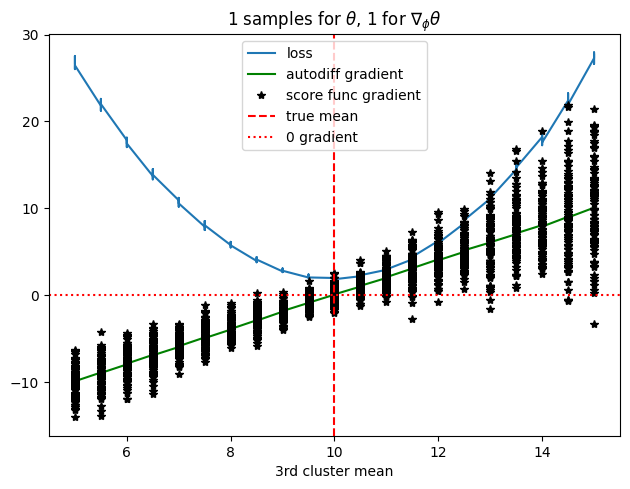

In [20]:
plot_big_results(big_analytical, autodiff_grads, losses, param_vals, T, M=2, limit_y=False, title=r'1 samples for $\theta$, 1 for $\nabla_\phi \theta$')

In [11]:
def plot_big_results(analytical_grads_MTS, autodiff_grads, losses, param_vals, T,M, num_rows=2, title=None, limit_y=True):
    analytical_grads = [tf.reduce_mean(tf.reduce_mean(grad_MTS[:num_rows,:,:], axis=0), axis=0) [0] for grad_MTS in analytical_grads_MTS]

    # plot with 2 different scales, 1 y axis for each graph:
    fig, ax1 = plt.subplots()

    # Plot the first line on ax1
    ax1.set_xlabel('3rd cluster mean')
    #ax1.set_ylabel('loss')
    ax1.plot(param_vals, losses, label='loss')
    
    ax1.tick_params(axis='y')
    if limit_y:
        ax1.set_ylim([-10, 10])
    plt.legend()
    # Create ax2, which shares the same x-axis as ax1
    ax2 = ax1#.twinx()
    #ax2.set_ylabel('gradient')
    # divide by 1000 because autodiff is summing over samples
    ax2.plot(param_vals, [mag/T for mag in autodiff_grads], 'g-', label='autodiff gradient')
    ax2.plot(param_vals, analytical_grads,'k*',label='score func gradient', )
    ax2.tick_params(axis='y')
    #ax2.set_ylim([-10,10])

    #ax2.set_ylim([-1000, 1000])
    #plot vertical line at x=25
    plt.axvline(x=10, color='r', linestyle='--', label='true mean')
    plt.axhline(y=0, color='r', linestyle=':', label='0 gradient')
    fig.tight_layout()
    plt.legend()

    if title is None:
        title = f'Loss and gradients score_func samples M={M}, first {num_rows} taken'

    plt.title(title)
    plt.show()
